# PR Lab 1: Face Recognition
#####Abdelrahman Elsayed - 20010795
#####Mohamed Amr Abdelfattah - 20011675
#####Omar Tarek Abdelwahab - 20010998

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle_token/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download kasikrit/att-database-of-faces

  0% 0.00/3.61M [00:00<?, ?B/s]
100% 3.61M/3.61M [00:00<00:00, 174MB/s]


In [ ]:
! unzip att-database-of-faces.zip

Archive:  att-database-of-faces.zip
  inflating: README                  
  inflating: s1/1.pgm                
  inflating: s1/10.pgm               
  inflating: s1/2.pgm                
  inflating: s1/3.pgm                
  inflating: s1/4.pgm                
  inflating: s1/5.pgm                
  inflating: s1/6.pgm                
  inflating: s1/7.pgm                
  inflating: s1/8.pgm                
  inflating: s1/9.pgm                
  inflating: s10/1.pgm               
  inflating: s10/10.pgm              
  inflating: s10/2.pgm               
  inflating: s10/3.pgm               
  inflating: s10/4.pgm               
  inflating: s10/5.pgm               
  inflating: s10/6.pgm               
  inflating: s10/7.pgm               
  inflating: s10/8.pgm               
  inflating: s10/9.pgm               
  inflating: s11/1.pgm               
  inflating: s11/10.pgm              
  inflating: s11/2.pgm               
  inflating: s11/3.pgm               
  inflating: s

##Imports

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from numpy.linalg import *
from numpy import asarray
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



```
# This is formatted as code
```

# Insert Non-Faces Data

In [ ]:
# Define the path to the folder containing the images
folder_path = '/content/drive/My Drive/modified'
file_list = os.listdir(folder_path)
print(file_list)

['nf18', 'nf11', 'nf15', 'nf14', 'nf1', 'nf12', 'nf17', 'nf10', 'nf16', 'nf13', 'nf20', 'nf21', 'nf26', 'nf2', 'nf19', 'nf22', 'nf23', 'nf25', 'nf24', 'nf27', 'nf3', 'nf32', 'nf28', 'nf35', 'nf34', 'nf33', 'nf31', 'nf36', 'nf30', 'nf29', 'nf9', 'nf39', 'nf7', 'nf40', 'nf38', 'nf8', 'nf37', 'nf5', 'nf6', 'nf4']


##2. Data Matrix and Label Vector

#####Image dimensions (w * h) = (92 * 112)
#####As nparray (rows * columns) = (112 * 92)

In [ ]:
#Read non faces images
rows_list_nonFace = []
for subFolderName in file_list:
  subFolder_path = os.path.join(folder_path,subFolderName)
  img_list = os.listdir(subFolder_path)
  for img in img_list:
    image_path = os.path.join(subFolder_path,img)
    img = cv2.imread(image_path)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rows_list_nonFace.append(
        asarray(gray_image).reshape((1, 112*92))
    )
# data matrix
data_nonFace = np.vstack(tuple(rows_list_nonFace))


In [ ]:
# label vector non face
labels_lst_nface = [1 for y in range(1, 40 + 1) for x in range(1, 10 + 1)]
labels_nface = np.array(labels_lst_nface)
labels_nface = labels_nface.reshape((400, 1))

In [ ]:
labels.shape

In [ ]:
# reading each image
# then converting it to a row vector
rows_list_face = []
for i in range(1, 40 + 1):
  for j in range(1, 10 + 1):
    img = Image.open(f"s{i}/{j}.pgm")
    rows_list_face .append(
        asarray(img).reshape((1, 112*92))
    )
# data matrix
data_faces = np.vstack(tuple(rows_list_face ))

In [ ]:
# labels vector face for compare with non face
labels_lst_face = [2 for y in range(1, 40 + 1) for x in range(1, 10 + 1)]
labels_face = np.array(labels_lst_face)
labels_face = labels_face.reshape((400, 1))

In [ ]:
labels_lst = [y for y in range(1, 40 + 1) for x in range(1, 10 + 1)]
labels = np.array(labels_lst)
labels = labels.reshape((400, 1))

##3. Splitting The Dataset

In [ ]:
#Function for split data
def split_data(rows_list):
  #odd rows for training
  training_data = np.vstack(tuple(
        [rows_list[i] for i in range(1, len(rows_list), 2)]
  ))

  #even rows for testing
  testing_data = np.vstack(tuple(
    [rows_list[i] for i in range(0, len(rows_list), 2)]
  ))
  return training_data,testing_data

In [ ]:
#Function for split labels
def split_labels(labels):
  training_labels = np.array(
    [labels[i] for i in range(1, len(labels), 2)]
  ).reshape((len(labels)//2, 1))
  testing_labels = np.array(
    [labels[i] for i in range(0, len(labels), 2)]
  ).reshape((len(labels)//2, 1))
  return training_labels, testing_labels

##4. Classification Using PCA

In [ ]:
def sort_eigen(eigenvalues, eigenvectors):
  idx = eigenvalues.argsort()[::-1]
  sorted_eval = eigenvalues[idx]
  sorted_evec = eigenvectors[:,idx]
  return sorted_eval, sorted_evec

def reduce_dimensionality(cov_eigenval, cov_eigenvec, alpha):
  # returns the projection matrix for given alpha
  # eigenvalues and eigenvectors must be sorted

  total_variance = np.sum(cov_eigenval)

  # current sum of chosen dominant eigenvalues
  curr_eigensum = 0
  # index to eigenvalue index list
  curr_eig_index = 0

  while curr_eigensum / total_variance < alpha:
    #updating the dominant eigenvalues sum
    curr_eigensum +=  cov_eigenval[curr_eig_index]
    curr_eig_index += 1

  return cov_eigenvec.T[:curr_eig_index + 1].T
  # return cov_eigenvec.T[:curr_eig_index + 1].T.real


def covariance_eigens_from_data(data: np.ndarray):
  """
  input:
    - training data matrix (n*d)
  output:
    - eigenvalues and eigenvectors of the covaraince matrix (d*d).
  """
  n, d = data.shape
  mean_vec = data.T @ np.ones((n, 1)) / n
  centered_data = data - np.ones((n, 1)) @ mean_vec.T
  #d*d --> very large, needs to be optimized
  covariance_mat = centered_data.T @ centered_data / n
  return eigh(covariance_mat)


In [ ]:
def normalize_data(mat):
  mat_min = mat.min(axis=0)
  mat_max = mat.max(axis=0)
  return np.uint8(np.round(255 * (mat - mat_min) / (mat_max- mat_min) ))

In [ ]:
def pca (training_data):
  # eigens from pca
  eigenval, eigenvec = covariance_eigens_from_data(training_data)

  #sorting eigens
  return sort_eigen(eigenval, eigenvec)


def classify_faces(
    training_mat,
    training_labels,
    testing_mat,
    testing_labels,
    sorted_eigenval,
    sorted_eigenvec,
    alpha_list
    ):
  accuracy_list = []

  for alpha in alpha_list:
    # projection matrix
    proj_mat = reduce_dimensionality(sorted_eigenval, sorted_eigenvec, alpha)

    # reduction of training and testing data
    reduced_training = training_mat @ proj_mat
    reduced_testing = testing_mat @ proj_mat

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(reduced_training, training_labels)

    accuracy_list.append(
        accuracy_score(testing_labels, knn.predict(reduced_testing))
    )

  return accuracy_list



In [ ]:

training_data_faces , testing_data_faces = split_data(rows_list_face)
training_labels_faces , testing_labels_faces = split_labels(labels)
# sorted_eigenval, sorted_eigenvec = pca(training_data_faces)

In [ ]:
alpha_list = [0.8, 0.85, 0.9, 0.95]


In [ ]:
accuracy_list = classify_faces(
    training_data_faces,
    training_labels_faces,
    testing_data_faces,
    testing_labels_faces,
    sorted_eigenval,
    sorted_eigenvec,
    alpha_list
)

In [ ]:
accuracy_list

In [ ]:
def getD(training_data, cluster_size):
  ind = 0
  D = []
  while ind < len(training_data):
    group = np.array(training_data[ind])
    for i in range(ind+1, ind + cluster_size):
      group = np.vstack([group, training_data[i]])
    ind += cluster_size
    D.append(group)
  return D

D = getD(training_data_faces, 5)
print(len(D))
print(D[0].shape)
print(D)

In [ ]:
def get_Sb(m, nks, data, D):
  mean_total = np.mean(data, axis=0)
  d = data.shape[1]
  Sb = np.zeros((d, d))
  print(mean_total.shape)
  print(Sb.shape)
  print(m, len(nks))
  for k in range(m):
    uk = np.mean(D[k], axis=0)
    uk = (uk - mean_total).reshape(d, 1)
    Sb += nks[k]*(uk).dot(uk.T)
  return Sb

In [ ]:
Sb = get_Sb(40, [5 for x in range(40)], training_data_faces, D)
print(Sb.shape)
print(Sb)

(10304,)
(10304, 10304)
40 40
(10304, 10304)
[[235278.32  232717.44  233560.64  ... -43174.56  -21703.44  -15646.88 ]
 [232717.44  230668.78  231142.03  ... -40923.52  -20191.43  -14642.46 ]
 [233560.64  231142.03  232523.155 ... -39926.72  -18941.855 -13273.41 ]
 ...
 [-43174.56  -40923.52  -39926.72  ... 360976.48  315665.12  312321.04 ]
 [-21703.44  -20191.43  -18941.855 ... 315665.12  294892.955 289157.81 ]
 [-15646.88  -14642.46  -13273.41  ... 312321.04  289157.81  289627.82 ]]


In [ ]:
def get_S(D, m, d):
  S = np.zeros((d, d))
  print(m, d)
  for k in range(m):
    mean_k = np.mean(D[k], axis=0)
    S += (D[k] - mean_k).T.dot((D[k] - mean_k))
  return S


In [ ]:
S = get_S(D, 40, data_faces.shape[1])
print(S.shape)
print(S)

40 10304
(10304, 10304)
[[ 28496.8  27128.2  27372.4 ...  -3977.2  -3511.6    539. ]
 [ 27128.2  28448.8  27518.6 ...  -2697.2  -2349.2   1781.6]
 [ 27372.4  27518.6  28698.4 ...  -3472.2   -923.2   3416.2]
 ...
 [ -3977.2  -2697.2  -3472.2 ... 140034.   83425.8  64222.2]
 [ -3511.6  -2349.2   -923.2 ...  83425.8  99585.6  82754.4]
 [   539.    1781.6   3416.2 ...  64222.2  82754.4 104148.8]]


In [ ]:
def get_eigs(SS, SB):
  X = np.linalg.inv(SS).dot(SB)
  w, v = np.linalg.eigh(X)
  return w, v

In [ ]:
w, v = get_eigs(S, Sb)
print(w.shape)
print(v.shape)

(10304,)
(10304, 10304)


In [ ]:
print(w)
print(v)
v = v.T
idxs = np.argsort(abs(w))[::-1]
eigenvalues = w[idxs]
eigenvectors = v[idxs]
print(eigenvalues)
print(eigenvectors)

[-1.13363577e+19 -5.67599743e+18 -3.60393996e+18 ...  3.64265939e+18
  5.62258133e+18  1.13809605e+19]
[[ 8.48040330e-03 -3.60603806e-03  2.10800516e-02 ... -2.11763471e-02
   3.40539171e-03 -8.32129618e-03]
 [ 8.37921947e-03 -3.19003732e-03  2.08637196e-02 ... -2.06794918e-02
   2.95499383e-03 -8.18635779e-03]
 [ 8.17594710e-03 -3.94777442e-03  2.08026492e-02 ... -2.09376584e-02
   3.75698090e-03 -8.02581305e-03]
 ...
 [ 9.48521935e-03 -5.38139223e-03 -4.67369325e-03 ... -3.72057109e-03
  -5.31315225e-03  9.53644578e-03]
 [ 6.94781897e-03 -1.06247449e-02 -4.96597235e-03 ... -4.95545765e-03
  -1.05509058e-02  7.02968690e-03]
 [-2.41868614e-03  9.39328027e-05 -2.33249788e-05 ... -5.59884875e-04
   1.17005530e-04 -2.46233210e-03]]
[ 1.13809605e+19 -1.13363577e+19 -5.67599743e+18 ...  5.50629424e+11
  3.03194673e+11 -5.48866349e+10]
[[-8.32129618e-03 -8.18635779e-03 -8.02581305e-03 ...  9.53644578e-03
   7.02968690e-03 -2.46233210e-03]
 [ 8.48040330e-03  8.37921947e-03  8.17594710e-03 ...

In [ ]:
eigen_vectors = eigenvectors[0:39]
print(eigen_vectors)

[[-8.32129618e-03 -8.18635779e-03 -8.02581305e-03 ...  9.53644578e-03
   7.02968690e-03 -2.46233210e-03]
 [ 8.48040330e-03  8.37921947e-03  8.17594710e-03 ...  9.48521935e-03
   6.94781897e-03 -2.41868614e-03]
 [-3.60603806e-03 -3.19003732e-03 -3.94777442e-03 ... -5.38139223e-03
  -1.06247449e-02  9.39328027e-05]
 ...
 [-1.15655637e-03 -1.52147790e-03 -8.82948842e-04 ... -2.34212686e-03
   1.60173638e-02  9.90543656e-03]
 [ 1.80932113e-02  1.91080445e-02  1.74053468e-02 ... -4.73034319e-03
   1.62260503e-02  1.14929691e-02]
 [-3.46413360e-02 -3.51334515e-02 -3.38248074e-02 ...  2.15653054e-02
   1.74646058e-02  1.96887732e-03]]


In [ ]:
def get_accuracy(
    Proj_mat,
    training_data,
    testing_data,
    training_labels,
    testing_labels,
    ):
  accuracy_list = []

  # reduction of training and testing data
  print(Proj_mat.shape)
  reduced_training = np.dot(training_data, Proj_mat.T)
  reduced_testing = np.dot(testing_data, Proj_mat.T)
  print(reduced_training.shape)
  print(reduced_testing.shape)
  knn = KNeighborsClassifier(n_neighbors=1)
  knn.fit(reduced_training, training_labels)

  accuracy_list.append(
      accuracy_score(testing_labels, knn.predict(reduced_testing))
  )

  return accuracy_list
get_accuracy(proj_mat, datamix, data_test, labels2, labels_test)

(39, 10304)
(280, 39)
(520, 39)


[0.8769230769230769]

(39, 10304)


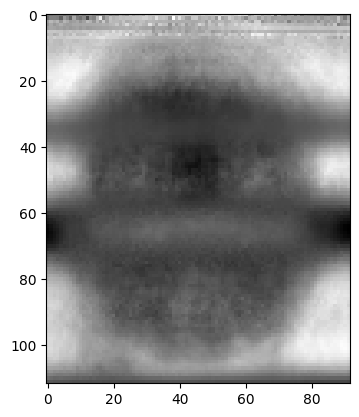

In [ ]:
import matplotlib.pyplot as plt
# imgs = []
# for i in range(1,40,5):
#   imgs.append(data[i].reshape(1, d))
# # img = img.dot(eigen_vectors.real.T).dot(eigen_vectors.real)
# print(img.shape)
# plt.figure(figsize=(16, 8))
# for i in range(5):
#   plt.subplot(1, 5, i+1)
#   plt.imshow(imgs[i].reshape(112, 92), cmap='gray')
# plt.show()
# plt.figure(figsize=(16, 8
# ))
# for i in range(5):
#   plt.subplot(1, 5, i+1)
# proj_mat = reduce_dimensionality(sorted_eigenval, sorted_eigenvec, .9)
print(proj_mat.shape)
plt.imshow(data_faces[1].dot(proj_mat.T).dot(proj_mat).reshape(112, 92), cmap='gray')
# plt.imshow(data[13].reshape(112, 92), cmap='gray')
plt.show()
# plt.imshow(data[14].reshape(112, 92), cmap='gray')
# plt.axis('off')

**7. Compare vs Non-Face Images**

In [ ]:
def get_datamix(fsize, nfsize, faces, nonfaces):
  labels2 = []
  datamix = []
  data_test = []
  labels_test = []
  ind = 0
  step = round(fsize / 40)
  while ind < 40:
    for i in range(ind * 10, ind * 10 + step):
      datamix.append(faces[i])
      labels2.append(1)
    for i in range(ind * 10 + step, ind * 10 + 10):
      data_test.append(faces[i])
      labels_test.append(1)
    ind += 1
  step = round(nfsize / 40)
  ind = 0
  while ind < 40:
      for i in range(ind * 10, ind * 10 + step):
        datamix.append(nonfaces[i])
        labels2.append(2)
      for i in range(ind * 10 + step, ind * 10 + 10):
        data_test.append(nonfaces[i])
        labels_test.append(2)
      ind += 1


  datamix = np.array(datamix)
  labels2 = np.array(labels2)
  data_test = np.array(data_test)
  labels_test = np.array(labels_test)
  return datamix, labels2, data_test, labels_test


In [ ]:
datamix, labels2, data_test, labels_test = get_datamix(200, 200, data_faces, data_nonFace)
print(datamix.shape)
print(labels2.shape)
print(data_test.shape)
print(labels_test.shape)

(400, 10304)
(400,)
(400, 10304)
(400,)


In [ ]:
sorted_eigenval, sorted_eigenvec = pca(datamix)

In [ ]:
def classify_faces(
        sorted_eigenval,
        sorted_eigenvec,
        training_data,
        testing_data,
        training_labels,
        testing_labels,
        alpha_list,
        ):

  accuracy_list = []

  for alpha in alpha_list:
    # projection matrix
    proj_mat = reduce_dimensionality(sorted_eigenval, sorted_eigenvec, alpha)
    print(proj_mat.shape)
    # reduction of training and testing data
    reduced_training = training_data @ proj_mat
    reduced_testing = testing_data @ proj_mat

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(reduced_training, training_labels)

    accuracy_list.append(
        accuracy_score(testing_labels, knn.predict(reduced_testing))
    )
  return accuracy_list , knn.predict(reduced_testing)



In [ ]:
alpha_list = [0.70, 0.75, 0.8, .85, .9, .95, 1]
accuracy_list , predict_labels = classify_faces(sorted_eigenval,
                                                  sorted_eigenvec,
                                                  datamix,
                                                  data_test,
                                                  labels2,
                                                  labels_test,
                                                  alpha_list,)
print(accuracy_list)

(10304, 11)
(10304, 17)
(10304, 27)
(10304, 44)
(10304, 75)
(10304, 138)
(10304, 400)
[0.94, 0.9425, 0.9375, 0.94, 0.9475, 0.9475, 0.9425]


In [ ]:
#To show the casses which success and failure
def show_success_failure(predict_labels,labels,data):
  for i in range(len(labels)):
    if(predict_labels[i] != labels[i]):
      # print ("Classification success")
      # plt.imshow(data[i].reshape(112, 92), cmap='gray')
      # plt.show()
    # else:
      print ("Classification Failure")
      plt.imshow(data[i].reshape(112, 92), cmap='gray')
      plt.show()

In [ ]:
show_success_failure(predict_labels,labels_test,data_test)

In [ ]:
# Try different number of non faces
numbers = [40, 80, 120, 160, 200]
list_accuracy = []
for i in numbers:
  datamix, labels2, data_test, labels_test = get_datamix(200, i, data_faces, data_nonFace)
  sorted_eigenval, sorted_eigenvec = pca(datamix)
  alpha_list = [0.9]
  accuracy_list , predict_labels = classify_faces(sorted_eigenval,
                                                  sorted_eigenvec,
                                                  datamix,
                                                  data_test,
                                                  labels2,
                                                  labels_test,
                                                  alpha_list,)
  list_accuracy.append(accuracy_list[0])

(10304, 76)
(10304, 76)
(10304, 76)
(10304, 76)
(10304, 76)


In [ ]:
list_accuracy

[0.9741379310344828, 0.9727272727272728, 0.9754716981132076, 0.975, 0.976]

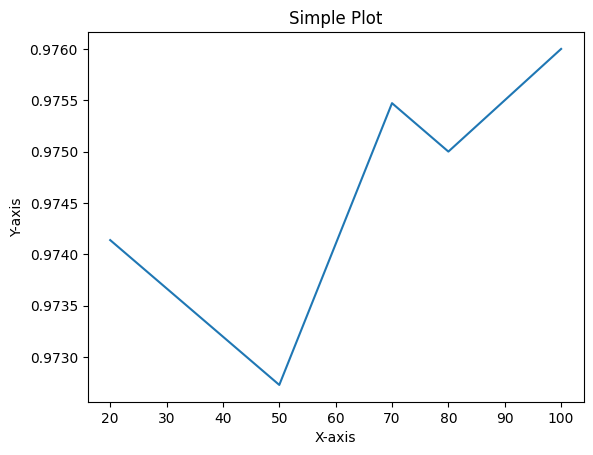

In [ ]:
#Plot the accuracy vs the number of non faces

# Sample data
x = numbers
y = list_accuracy

# Plot the data
plt.plot(x, y)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Plot')

# Show the plot
plt.show()